In [1]:
import os
import sys
# Only for final delivery
import warnings
warnings.filterwarnings('ignore')
# libraries for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="white")
# Libraries models
import pandas as pd
import numpy as np
from collections import Counter
from time import time
# Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
import seaborn as sns
# Library's to apply balance technic's
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the necessary module's
from scipy.stats import chi2
from sklearn.preprocessing import MinMaxScaler,binarize
from sklearn.feature_selection import SelectKBest,mutual_info_classif,chi2,RFE,RFECV,SelectFromModel
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate,cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,average_precision_score
from sklearn.metrics import roc_curve,classification_report,confusion_matrix,make_scorer
from sklearn.naive_bayes import ComplementNB
from xgboost import XGBRegressor,XGBClassifier
# library to save the models
import joblib

In [2]:
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

In [3]:
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
os.chdir(directory_path)
os.getcwd()

'/Users/iairlinker/Documents/repos/flight_delays_challenge'

### Loading pre-processed dataset

In [4]:
path = os.getcwd() + '/data/interim/model_data.csv' 
df = pd.read_csv(path, sep=',')
X = df.copy()
y = X.atraso_15
X.drop('atraso_15', axis=1, inplace=True)
get_na(X)

,datos sin NAs en q,Na en q,Na en %
onehotencoder__x0_EGLL,68206,0,0.0
onehotencoder__x4_Martes,68206,0,0.0
onehotencoder__x1_UAL,68206,0,0.0
onehotencoder__x2_N,68206,0,0.0
onehotencoder__x3_morning,68206,0,0.0
...,...,...,...
onehotencoder__x0_SCVD,68206,0,0.0
onehotencoder__x0_SEGU,68206,0,0.0
onehotencoder__x0_SEQM,68206,0,0.0
onehotencoder__x0_SGAS,68206,0,0.0


### Split the dataset and create to kind of train and test datasets: unbalanced and balanced with random-under-sample since the objective variable only happens in  18.5% of the flights

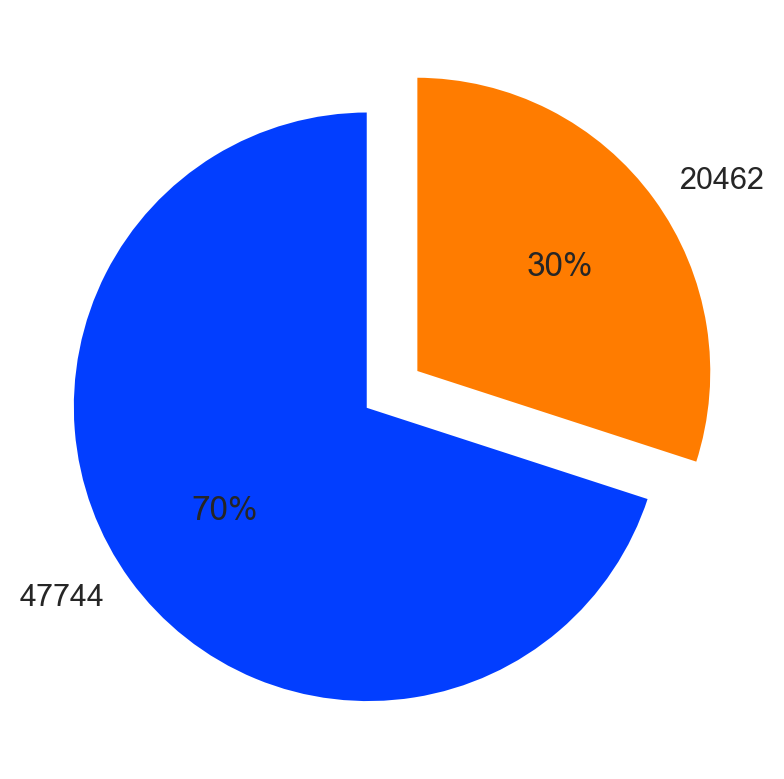

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)
#define data
data = [X_train.shape[0],X_test.shape[0] ]
labels = [data[0], data[1]]
#define Seaborn color palette to use
colors = sns.color_palette('bright')[0:2]
#create pie chart
plt.pie(data, labels = labels, colors = colors,startangle=90, 
        autopct='%1.f%%',explode=(0.1,0.1))
plt.show()

Información del dataset:
 las clases del target son: Counter({0.0: 55592, 1.0: 12614})


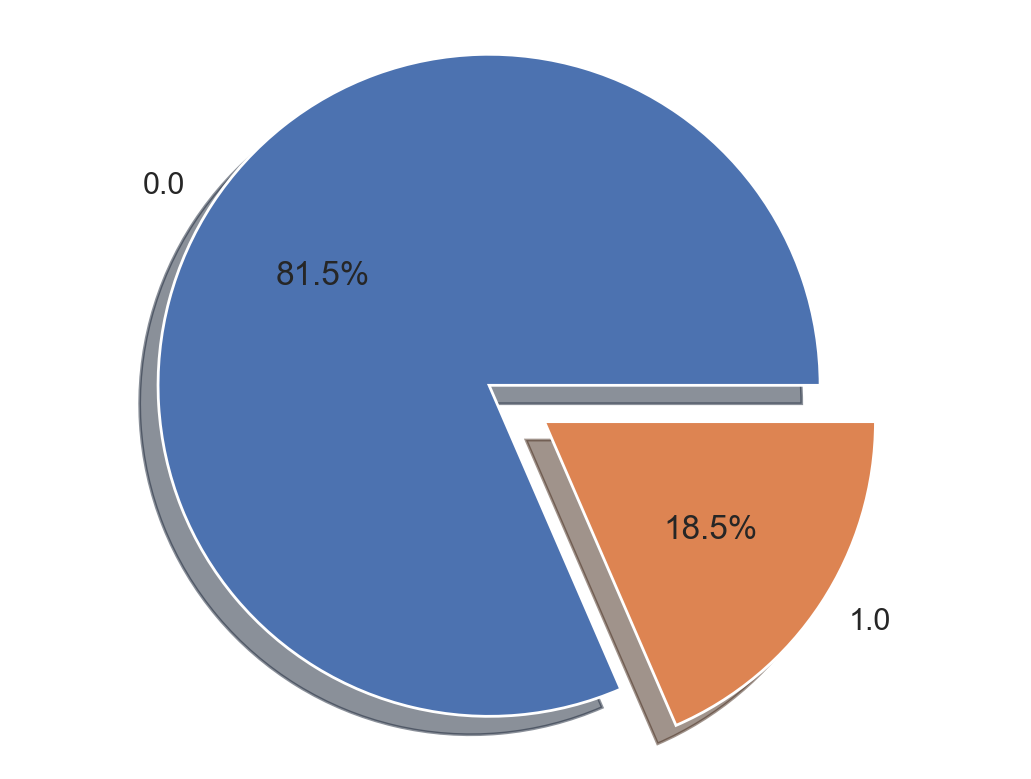

In [6]:
print('Información del dataset:'
      '\n las clases del target son: {}'.format(Counter(y)))
plot_pie(y)

Información del dataset aplicando el algoritmo Smote:
 y: Counter({0.0: 17624, 1.0: 8812})


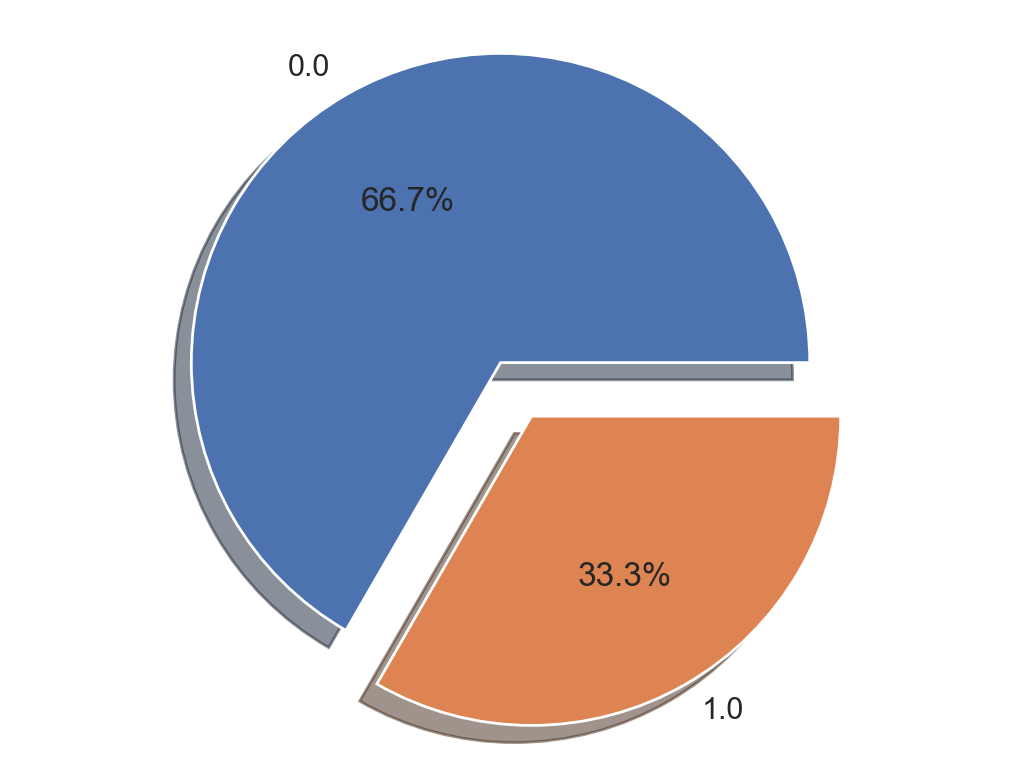

In [7]:
# sm = SMOTE(random_state=0,n_jobs=-1)
# X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
under = RandomUnderSampler(sampling_strategy=0.5)
X_train_res, y_train_res = under.fit_resample(X_train, y_train)
print('Información del dataset aplicando el algoritmo Smote:'
      '\n y: {}'.format(Counter(y_train_res)))
plot_pie(y_train_res)

In [8]:
clf = ComplementNB(alpha=0.1,class_prior = [81.5,18.5] )
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print(scores.mean())
clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test, y_pred)
print(report)
cm

0.2746383115209153
              precision    recall  f1-score   support

         0.0       0.88      0.65      0.75     16660
         1.0       0.28      0.60      0.38      3802

    accuracy                           0.64     20462
   macro avg       0.58      0.62      0.56     20462
weighted avg       0.77      0.64      0.68     20462



Predicted class,0.0,1.0,All
Actual class,,,
0.0,10794,5866,16660
1.0,1516,2286,3802
All,12310,8152,20462


In [9]:
clf = ComplementNB(alpha=1,class_prior = [81.5,18.5] )
scores = cross_val_score(clf, X_train_res, y_train_res, cv=10, scoring='precision')
print(scores.mean())
clf.fit(X_train_res, y_train_res)
clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test, y_pred)
print(report)
cm

0.4551441357458903
              precision    recall  f1-score   support

         0.0       0.88      0.65      0.75     16660
         1.0       0.28      0.60      0.38      3802

    accuracy                           0.64     20462
   macro avg       0.58      0.62      0.56     20462
weighted avg       0.77      0.64      0.68     20462



Predicted class,0.0,1.0,All
Actual class,,,
0.0,10815,5845,16660
1.0,1523,2279,3802
All,12338,8124,20462


In [10]:
clf = RandomForestClassifier(n_estimators=500,random_state=0,warm_start=True,criterion='gini',
                             bootstrap=True,max_features='sqrt')
scores = cross_val_score(clf, X_train_res, y_train_res, cv=10, scoring='precision')
print(scores.mean())
clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
report = classification_report(y_test, y_pred)
cm = pd.crosstab(y_test, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test, y_pred)
print(report)
cm

0.5529620062327675
              precision    recall  f1-score   support

         0.0       0.84      0.93      0.88     16660
         1.0       0.41      0.21      0.28      3802

    accuracy                           0.80     20462
   macro avg       0.62      0.57      0.58     20462
weighted avg       0.76      0.80      0.77     20462



Predicted class,0.0,1.0,All
Actual class,,,
0.0,15539,1121,16660
1.0,3015,787,3802
All,18554,1908,20462


In [11]:
clf = DecisionTreeClassifier(random_state=0, max_features='sqrt',criterion='gini',
                             min_samples_split=0.001)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print(scores.mean())
clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test, y_pred)
print(report)
cm

0.4474822451125308
              precision    recall  f1-score   support

         0.0       0.83      0.97      0.89     16660
         1.0       0.47      0.13      0.21      3802

    accuracy                           0.81     20462
   macro avg       0.65      0.55      0.55     20462
weighted avg       0.76      0.81      0.77     20462



Predicted class,0.0,1.0,All
Actual class,,,
0.0,16094,566,16660
1.0,3296,506,3802
All,19390,1072,20462


In [12]:
clf = LogisticRegression()
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print(scores.mean())
clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test, y_pred)
print(report)
cm

0.5039319157595821
              precision    recall  f1-score   support

         0.0       0.82      0.99      0.90     16660
         1.0       0.54      0.04      0.08      3802

    accuracy                           0.82     20462
   macro avg       0.68      0.52      0.49     20462
weighted avg       0.77      0.82      0.75     20462



Predicted class,0.0,1.0,All
Actual class,,,
0.0,16518,142,16660
1.0,3633,169,3802
All,20151,311,20462


In [13]:
clf = XGBClassifier(random_state=0,verbosity = 0)
scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='precision')
print(scores.mean())
clf.fit(X_train, y_train)
y_pred_probs = clf.predict_proba(X_test)[:,1]
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test, y_pred)
print(report)
cm

0.6135100337142173
              precision    recall  f1-score   support

         0.0       0.83      0.98      0.90     16660
         1.0       0.61      0.14      0.23      3802

    accuracy                           0.82     20462
   macro avg       0.72      0.56      0.57     20462
weighted avg       0.79      0.82      0.78     20462



Predicted class,0.0,1.0,All
Actual class,,,
0.0,16308,352,16660
1.0,3259,543,3802
All,19567,895,20462


### Hyperparameter tunning

In [14]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

In [15]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42,
    booster='gbtree',
    eval_metric='auc',
    tree_method='hist',
    grow_policy='lossguide',
    use_label_encoder=False,
    verbosity = 0,
    silent=True
)

In [16]:
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}

In [17]:
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'precision',
    n_jobs = 10,
    cv = 10,
    verbose=False
)

In [18]:
grid_search.fit(X_train, y_train)

/opt/miniconda3/envs/flyght_delay_challenge/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/miniconda3/envs/flyght_delay_challenge/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/miniconda3/envs/flyght_delay_challenge/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/opt/miniconda3/envs/flyght_delay_challenge/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64In

GridSearchCV(cv=10,
             estimator=XGBClassifier(base_score=None, booster='gbtree',
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False,
                                     eval_metric='auc', gamma=None, gpu_id=None,
                                     grow_policy='lossguide',
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_wei...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None, nthread=4,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     seed=42, silent=True, subsample=None, ...),
             n_jobs=10,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)},
             scoring='precision', verbose=False)

In [21]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='lossguide',
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=60, n_jobs=4, nthread=4, num_parallel_tree=1,
              predictor='auto', random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=42, silent=True, subsample=1, ...)

In [22]:
y_pred_probs = grid_search.predict_proba(X_test)[:,1]
y_pred = grid_search.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Actual class'], colnames=['Predicted class'],margins=True)
report = classification_report(y_test, y_pred)
print(report)
cm

              precision    recall  f1-score   support

         0.0       0.82      1.00      0.90     16660
         1.0       0.77      0.02      0.03      3802

    accuracy                           0.82     20462
   macro avg       0.79      0.51      0.46     20462
weighted avg       0.81      0.82      0.74     20462



Predicted class,0,1,All
Actual class,,,
0.0,16642,18,16660
1.0,3741,61,3802
All,20383,79,20462
